# Milestone 3

## Zaawansowane modele i optymalizacja

- Modele ensemble
- Tuning hiperparametrów

## Walidacja i ocena końcowa

- Testowanie modelu na zbiorze testowym
- Użycie metryk i narzędzi do walidacji

## Interpretacja i wyjaśnienie wyników

- Feature importance
- Wykorzystanie narzędzi interpretacyjnych

## Przygotowanie raportu

In [1]:
import warnings

import sklearn.metrics

warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate

filepath = "data/creditcard_csv.csv"

df = pd.read_csv(filepath)

X = df.drop('Class', axis=1)
y = df['Class'].replace({"'0'": 0, "'1'": 1})

# dzielimy
X_train_valid, X_test, y_train_valid, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import pandas as pd

class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, amount_log=False, Vcolumns_log=False):
        self.amount_log = amount_log
        self.Vcolumns_log = Vcolumns_log

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        if 'Time' in X.columns:
            X.drop('Time', axis=1, inplace=True)

        if self.amount_log and 'Amount' in X.columns:
            X['Amount'] = np.log1p(X['Amount'])

        if self.Vcolumns_log:
            V_cols = [col for col in X.columns if 'V' in col]
            X[V_cols] = X[V_cols].apply(np.abs) # wartosc bezwzgledna w celu poprawnego nalozenia logarytmu
            X[V_cols] = X[V_cols].apply(np.log1p)
        return X


## Funkcja kosztu

In [3]:
# funkcja kosztu

class CustomCost:
    def __init__(self, X_with_amount):
        self.X_with_amount = X_with_amount

    def __call__(self, estimator, x, y_true):
        y_pred = estimator.predict(X)
        amount = self.X_with_amount.loc[y_true.index, 'Amount'].values

        fp_cost = 5
        tp_cost = 5
        tn_cost = 0

        total_cost = 0

        for true_label, pred_label, fn_cost in zip(y_true, y_pred, amount):
            if true_label == 0 and pred_label == 0: #TN
                total_cost += tn_cost
            elif true_label == 1 and pred_label == 0: #FN
                total_cost += fn_cost
            elif true_label == 0 and pred_label == 1: #FP
                total_cost += fp_cost
            elif true_label == 1 and pred_label == 1: #TP
                total_cost += tp_cost

        return -total_cost # ujemne bo wieksza wartosc = lepsze

## Klasyfikator głosujący

In [13]:
from sklearn.metrics import make_scorer, fbeta_score

scoring = {
    'recall': 'recall',
    'precision': 'precision',
    'f2': make_scorer(fbeta_score, beta=2), # f2 daje recall dwa razy ważniejszy od precision
    'roc_auc': 'roc_auc',
    'cost': CustomCost(X_with_amount=X)
}

def display_scores(scores):
    print("Wyniki recall:", scores['test_recall'])
    print("Średnia recall:", scores['test_recall'].mean())
    print("Odchylenie standardowe recall:", scores['test_recall'].std())
    print("Wyniki precision:", scores['test_precision'])
    print("Średnia precision:", scores['test_precision'].mean())
    print("Odchylenie standardowe precision:", scores['test_precision'].std())
    print("Wyniki f2:", scores['test_f2'])
    print("Średnia f2:", scores['test_f2'].mean())
    print("Odchylenie standardowe f2:", scores['test_f2'].std())
    print("Wyniki auc_roc:", scores['test_roc_auc'])
    print("Średnia auc_roc:", scores['test_roc_auc'].mean())
    print("Odchylenie standardowe auc_roc:", scores['test_roc_auc'].std())
    print("Wyniki fraud_cost:", scores['test_cost'])
    print("Średnia fraud_cost:", scores['test_cost'].mean())
    print("Odchylenie standardowe fraud_cost:", scores['test_cost'].std())

In [14]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

voting_clf = VotingClassifier(
    estimators=[('lr', LogisticRegression(max_iter=1000)),
                ('rf', RandomForestClassifier()),
                ('svc', SVC(kernel='poly', probability=True))],
    voting='soft'
)

cv_voting_clf = cross_validate(voting_clf, X_train_valid, y_train_valid, cv=5, scoring=scoring, n_jobs=-1)

display_scores(cv_voting_clf)

Wyniki recall: [0.6746988  0.62650602 0.51190476 0.52380952 0.64285714]
Średnia recall: 0.5959552495697074
Odchylenie standardowe recall: 0.06573153522579366
Wyniki precision: [0.96551724 0.96296296 1.         0.95652174 0.98181818]
Średnia precision: 0.9733640250581779
Odchylenie standardowe precision: 0.015712190361037555
Wyniki f2: [0.71794872 0.67357513 0.56728232 0.57591623 0.69053708]
Średnia f2: 0.6450518968295204
Odchylenie standardowe f2: 0.06168349987388023
Wyniki auc_roc: [0.98667854 0.97882755 0.94438804 0.95829232 0.97886611]
Średnia auc_roc: 0.9694105116278262
Odchylenie standardowe auc_roc: 0.015658938855721432
Wyniki fraud_cost: [ -9370.59 -10092.81 -13860.95  -7020.62 -14269.94]
Średnia fraud_cost: -10922.982
Odchylenie standardowe fraud_cost: 2762.655225433677


Słabe. Jedyna opcja taka, żeby dostroić te pojedyńcze klasyfikatory na boku i je tu włożyć. Dużo pracy imo

In [8]:
from sklearn.metrics import get_scorer_names

get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'd2_absolute_error_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_max_error',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'neg_root_mean_squared_log_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 're

## Agregacja

In [15]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import BaggingClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier


bag_clf = Pipeline([
    ('CustomTransformer', CustomTransformer()),
    ('Selectkbest', SelectKBest(score_func=f_classif, k=7)),
    ('bagging_clf', BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=100,
    bootstrap=True, n_jobs=-1),
     )
])

cv_bag_clf = cross_validate(bag_clf, X_train_valid, y_train_valid, scoring=scoring, cv=5)

display_scores(cv_bag_clf)

Wyniki recall: [0.85542169 0.78313253 0.71428571 0.72619048 0.77380952]
Średnia recall: 0.7705679862306368
Odchylenie standardowe recall: 0.050011165459326296
Wyniki precision: [0.91025641 0.92857143 0.83333333 0.96825397 0.92857143]
Średnia precision: 0.9137973137973139
Odchylenie standardowe precision: 0.04447261246952489
Wyniki f2: [0.86585366 0.80845771 0.73529412 0.76441103 0.80049261]
Średnia f2: 0.7949018252065582
Odchylenie standardowe f2: 0.04411790822237613
Wyniki auc_roc: [0.94513466 0.93893333 0.9037449  0.90380549 0.94580357]
Średnia auc_roc: 0.9274843905552854
Odchylenie standardowe auc_roc: 0.019506182699066916
Wyniki fraud_cost: [ -9505.59 -10232.81 -13995.95  -7150.62 -14384.94]
Średnia fraud_cost: -11053.982
Odchylenie standardowe fraud_cost: 2758.932150419071


In [18]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import BaggingClassifier
from sklearn.pipeline import Pipeline

bag_svm_clf = Pipeline([
    ('CustomTransformer', CustomTransformer()),
    ('Selectkbest', SelectKBest(score_func=f_classif, k=10)),
    ('bagging_clf', BaggingClassifier(
    SVC(kernel='poly'), n_estimators=10,
    bootstrap=True, n_jobs=-1),
     )
])

cv_bag_svm_clf = cross_validate(bag_svm_clf, X_train_valid, y_train_valid, scoring=scoring, cv=5)

display_scores(cv_bag_svm_clf)

Wyniki recall: [0.75903614 0.69879518 0.72619048 0.61904762 0.73809524]
Średnia recall: 0.7082329317269076
Odchylenie standardowe recall: 0.04865858263973289
Wyniki precision: [0.88732394 0.89230769 0.82432432 0.89655172 0.91176471]
Średnia precision: 0.8824544780628545
Odchylenie standardowe precision: 0.030191833669298642
Wyniki f2: [0.78163772 0.73047859 0.74390244 0.65989848 0.76732673]
Średnia f2: 0.7366487910794521
Odchylenie standardowe f2: 0.042299969387736634
Wyniki auc_roc: [0.90688039 0.90941745 0.89446577 0.88985712 0.88475389]
Średnia auc_roc: 0.8970749241985189
Odchylenie standardowe auc_roc: 0.009583292045053225
Wyniki fraud_cost: [ -9455.59 -10207.81 -13950.95  -7105.62 -14364.94]
Średnia fraud_cost: -11016.982
Odchylenie standardowe fraud_cost: 2764.3606129837694


In [19]:
from sklearn.ensemble import GradientBoostingClassifier

xgb_clf = Pipeline([
    ('CustomTransformer', CustomTransformer()),
    ('SelectKBest', SelectKBest(score_func=f_classif, k=10)),
    ('xgb_clf', GradientBoostingClassifier())
])

cv_xgb_clf = cross_validate(xgb_clf, X_train_valid, y_train_valid, scoring=scoring, cv=5, n_jobs=-1)

display_scores(cv_xgb_clf)

Wyniki recall: [0.42168675 0.72289157 0.60714286 0.19047619 0.73809524]
Średnia recall: 0.5360585197934595
Odchylenie standardowe recall: 0.20653641546392665
Wyniki precision: [0.79545455 0.84507042 0.89473684 0.57142857 0.83783784]
Średnia precision: 0.7889056438722857
Odchylenie standardowe precision: 0.11321506051633615
Wyniki f2: [0.46542553 0.74441687 0.64885496 0.21978022 0.75609756]
Średnia f2: 0.5669150295903831
Odchylenie standardowe f2: 0.20239257969140567
Wyniki auc_roc: [0.5915957  0.84322318 0.78552438 0.40719653 0.86887151]
Średnia auc_roc: 0.6992822616194381
Odchylenie standardowe auc_roc: 0.17540106987831755
Wyniki fraud_cost: [ -9040.29 -10307.81 -14076.46  -6780.62 -14509.94]
Średnia fraud_cost: -10943.024
Odchylenie standardowe fraud_cost: 2962.7963641438478


Wszedłbym w drzewa losowe

## Losowe lasy oraz zespół Extra-Trees

Tutaj będzie cały proces

In [26]:
def print_scores(scores):
    for f2, recall, precision, auc_roc, cost, params in zip(scores['mean_test_f2'], scores['mean_test_recall'],
                                                  scores['mean_test_precision'], scores['mean_test_roc_auc'],
                                                  scores['mean_test_cost'], scores['params']):
        print(params,
            '\nf2: ', f2,
            'recall: ', recall,
            'cost: ', cost,
            'auc_roc: ', auc_roc,
            'precision: ', precision, '\n')

### Losowe lasy

#### Randomized Search

Na początku robimy przeszukiwanie losowe w celu obrania jakiegoś kierunku

In [48]:
from sklearn.model_selection import RandomizedSearchCV

rnd_clf = Pipeline([
    ('CustomTransformer', CustomTransformer()),
    ('SelectKBest', SelectKBest(score_func=f_classif)),
    ('Classifier', RandomForestClassifier(n_jobs=-1, random_state=42)),
])

param_grid = {
    'SelectKBest__k': [5,8,10,13,15],
    'Classifier__n_estimators': [50,100,200,300,400,500],
    'Classifier__max_depth': [5,10,15,20],
    'Classifier__min_samples_split': [2,3,4],
    'Classifier__min_samples_leaf': [1,2,3,4],
    'Classifier__bootstrap': [True,False]
}

rnd_random_search = RandomizedSearchCV(rnd_clf, param_grid, cv=5, n_jobs=-1, scoring=scoring, refit=False, return_train_score=True, n_iter=20)

rnd_random_search.fit(X_train_valid, y_train_valid)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('CustomTransformer',
                                              CustomTransformer()),
                                             ('SelectKBest', SelectKBest()),
                                             ('Classifier',
                                              RandomForestClassifier(n_jobs=-1,
                                                                     random_state=42))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'Classifier__bootstrap': [True, False],
                                        'Classifier__max_depth': [5, 10, 15,
                                                                  20],
                                        'Classifier__min_samples_leaf': [1, 2,
                                                                         3, 4],
                                        'Classifier__min_samples_split': [2, 3,
                                                                          4],
                                        'Classifier__n_estimators': [50, 100,
                                                                     200, 300,
                                                                     400, 500],
                                        'SelectKBest__k': [5, 8, 10, 13, 15]},
                   refit=False, return_train_score=True,
                   scoring={'cost': <__main__.CustomCost object at 0x000002046604E190>,
                            'f2': make_scorer(fbeta_score, response_method='predict', beta=2),
                            'precision': 'precision', 'recall': 'recall',
                            'roc_auc': 'roc_auc'})

In [52]:
print_scores(rnd_random_search.cv_results_)

{'SelectKBest__k': 5, 'Classifier__n_estimators': 100, 'Classifier__min_samples_split': 4, 'Classifier__min_samples_leaf': 1, 'Classifier__max_depth': 15, 'Classifier__bootstrap': True} 
f2:  0.7948295123822284 recall:  0.7705966724039014 cost:  -11045.982 auc_roc:  0.9634607191900105 precision:  0.9139640071602096 

{'SelectKBest__k': 5, 'Classifier__n_estimators': 300, 'Classifier__min_samples_split': 4, 'Classifier__min_samples_leaf': 3, 'Classifier__max_depth': 15, 'Classifier__bootstrap': True} 
f2:  0.7940346549845604 recall:  0.7705966724039014 cost:  -11012.922000000002 auc_roc:  0.9655991855854158 precision:  0.907761833424896 

{'SelectKBest__k': 13, 'Classifier__n_estimators': 500, 'Classifier__min_samples_split': 2, 'Classifier__min_samples_leaf': 1, 'Classifier__max_depth': 15, 'Classifier__bootstrap': True} 
f2:  0.8061942400516185 recall:  0.7801204819277109 cost:  -11036.982 auc_roc:  0.9802501926351976 precision:  0.934719918982214 

{'SelectKBest__k': 10, 'Classifier_

In [53]:
pd.DataFrame(rnd_random_search.cv_results_).to_excel('grid_search_results/random_search.xlsx', index=False)

##### Odczyt wyników
Liczba używanych features nie koniecznie oznaczała lepsze wyniki. Jednak małe wartości tj. 5 oraz 8 nie działają zbyt dobrze. Zbyt głebokie drzewa/lasy zmniejszają precyzję modelu. Wydaje się, że większa wartość hiperparametru "min_samples_split" pozytywnie wpływa na pełność (recall). Wartości kosztu są bardzo podobne dla wszystkich modeli. Wartość bootstrap ustawiona na True negatywnie wpływa na jakość modelu.

#### Grid Search

In [33]:
from sklearn.model_selection import GridSearchCV

rnd_clf = Pipeline([
    ('CustomTransformer', CustomTransformer()),
    ('SelectKBest', SelectKBest(score_func=f_classif)),
    ('Classifier', RandomForestClassifier(n_jobs=-1, random_state=42)),
])

param_grid = [
    {'SelectKBest__k': [6,8,10]},
    {'Classifier__n_estimators': [50,100,200], 'Classifier__max_depth': [5,10]},
    {'Classifier__criterion': ['gini', 'entropy']},
]

rnd_grid_search = GridSearchCV(rnd_clf, param_grid, cv=5, n_jobs=-1, scoring=scoring, refit=False, return_train_score=True)

rnd_grid_search.fit(X_train_valid, y_train_valid)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('CustomTransformer',
                                        CustomTransformer()),
                                       ('SelectKBest', SelectKBest()),
                                       ('Classifier',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid=[{'SelectKBest__k': [6, 8, 10]},
                         {'Classifier__max_depth': [5, 10],
                          'Classifier__n_estimators': [50, 100, 200]},
                         {'Classifier__criterion': ['gini', 'entropy']}],
             refit=False, return_train_score=True,
             scoring={'cost': <__main__.CustomCost object at 0x000002046604E190>,
                      'f2': make_scorer(fbeta_score, response_method='predict', beta=2),
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [34]:
print_scores(rnd_grid_search.cv_results_)

{'SelectKBest__k': 6} 
f2:  0.8005215186507245 recall:  0.7753585771658061 cost:  -11057.982 auc_roc:  0.930592056704082 precision:  0.9248162569471873 

{'SelectKBest__k': 8} 
f2:  0.809666107726134 recall:  0.7849397590361445 cost:  -11056.982 auc_roc:  0.9303919518939365 precision:  0.9303714378744032 

{'SelectKBest__k': 10} 
f2:  0.8132911976088304 recall:  0.7872920252438325 cost:  -11055.982 auc_roc:  0.9413165497995027 precision:  0.9411203246834449 

{'Classifier__max_depth': 5, 'Classifier__n_estimators': 50} 
f2:  0.788256318620842 recall:  0.7633964429145152 cost:  -11077.024 auc_roc:  0.9626050257800708 precision:  0.9092575268052372 

{'Classifier__max_depth': 5, 'Classifier__n_estimators': 100} 
f2:  0.7903833192999561 recall:  0.7657773952954676 cost:  -11072.024 auc_roc:  0.970123757035115 precision:  0.9097741253979514 

{'Classifier__max_depth': 5, 'Classifier__n_estimators': 200} 
f2:  0.7920457235242461 recall:  0.76815834767642 cost:  -11073.024 auc_roc:  0.971686

In [42]:
pd.DataFrame(rnd_grid_search.cv_results_).to_excel('grid_search_results/rnd_grid_search_1.xlsx', index=False)

In [55]:
param_grid = [
    {'SelectKBest__k': [10, 12, 14, 16],
     'Classifier__n_estimators': [200, 300, 400],
     'Classifier__max_depth': [8,10,12],
     'Classifier__criterion': ['entropy']},
    {'Classifier__min_samples_split': [2,3,4,5,6],
     'Classifier__criterion': ['entropy'],
     'SelectKBest__k': [10]},
    {'Classifier__min_samples_leaf': [1,2,3,4],
     'Classifier__criterion': ['entropy'],
     'SelectKBest__k': [10]}
]

rnd_grid_search = GridSearchCV(rnd_clf, param_grid, cv=5, n_jobs=-1, scoring=scoring, refit=False, return_train_score=True)

rnd_grid_search.fit(X_train_valid, y_train_valid)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('CustomTransformer',
                                        CustomTransformer()),
                                       ('SelectKBest', SelectKBest()),
                                       ('Classifier',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid=[{'Classifier__criterion': ['entropy'],
                          'Classifier__max_depth': [8, 10, 12],
                          'Classifier__n_estimators': [200, 300, 400],
                          'SelectKBest__k': [10, 12, 14, 16]},
                         {...
                          'SelectKBest__k': [10]},
                         {'Classifier__criterion': ['entropy'],
                          'Classifier__min_samples_leaf': [1, 2, 3, 4],
                          'SelectKBest__k': [10]}],
             refit=False, return_train_score=True,
             scoring={'cost': <__main__.CustomCost object at 0x000002046604E190>,
                      'f2': make_scorer(fbeta_score, response_method='predict', beta=2),
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [56]:
print_scores(rnd_grid_search.cv_results_)

{'Classifier__criterion': 'entropy', 'Classifier__max_depth': 8, 'Classifier__n_estimators': 200, 'SelectKBest__k': 10} 
f2:  0.8163455169795967 recall:  0.7944635685599541 cost:  -11028.922 auc_roc:  0.9819242384871281 precision:  0.9204805598129928 

{'Classifier__criterion': 'entropy', 'Classifier__max_depth': 8, 'Classifier__n_estimators': 200, 'SelectKBest__k': 12} 
f2:  0.8071854318616 recall:  0.7824727481353987 cost:  -11032.922000000002 auc_roc:  0.9823505647575044 precision:  0.9269204174820613 

{'Classifier__criterion': 'entropy', 'Classifier__max_depth': 8, 'Classifier__n_estimators': 200, 'SelectKBest__k': 14} 
f2:  0.8067638576570643 recall:  0.7825014343086633 cost:  -11030.922 auc_roc:  0.9816276716690565 precision:  0.9243088886600063 

{'Classifier__criterion': 'entropy', 'Classifier__max_depth': 8, 'Classifier__n_estimators': 200, 'SelectKBest__k': 16} 
f2:  0.8050798032444032 recall:  0.7800917957544463 cost:  -11011.922000000002 auc_roc:  0.9826995738749293 precis

In [57]:
pd.DataFrame(rnd_grid_search.cv_results_).to_excel('grid_search_results/rnd_grid_search_2.xlsx', index=False)

In [59]:
param_grid = [
    {'SelectKBest__k': [9, 10, 11],
     'Classifier__n_estimators': [300],
     'Classifier__max_depth': [12,14,15]},
    {'Classifier__n_estimators': [350, 400, 500]},
]

rnd_clf = Pipeline([
    ('CustomTransformer', CustomTransformer()),
    ('SelectKBest', SelectKBest(score_func=f_classif)),
    ('Classifier', RandomForestClassifier(n_jobs=-1, random_state=42, criterion='entropy')), # na pewno entropia jako kryterium
])

rnd_grid_search = GridSearchCV(rnd_clf, param_grid, cv=5, n_jobs=-1, scoring=scoring, refit=False, return_train_score=True)

rnd_grid_search.fit(X_train_valid, y_train_valid)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('CustomTransformer',
                                        CustomTransformer()),
                                       ('SelectKBest', SelectKBest()),
                                       ('Classifier',
                                        RandomForestClassifier(criterion='entropy',
                                                               n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid=[{'Classifier__max_depth': [12, 14, 15],
                          'Classifier__n_estimators': [300],
                          'SelectKBest__k': [9, 10, 11]},
                         {'Classifier__n_estimators': [350, 400, 500]}],
             refit=False, return_train_score=True,
             scoring={'cost': <__main__.CustomCost object at 0x000002046604E190>,
                      'f2': make_scorer(fbeta_score, response_method='predict', beta=2),
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [60]:
print_scores(rnd_grid_search.cv_results_)

{'Classifier__max_depth': 12, 'Classifier__n_estimators': 300, 'SelectKBest__k': 9} 
f2:  0.8149534211101344 recall:  0.7896729776247848 cost:  -11029.982 auc_roc:  0.9819846617743597 precision:  0.9385874462534446 

{'Classifier__max_depth': 12, 'Classifier__n_estimators': 300, 'SelectKBest__k': 10} 
f2:  0.820776693378568 recall:  0.7968445209409065 cost:  -11031.982 auc_roc:  0.9799121249204348 precision:  0.9359898416025418 

{'Classifier__max_depth': 12, 'Classifier__n_estimators': 300, 'SelectKBest__k': 11} 
f2:  0.8144402183259072 recall:  0.7896729776247848 cost:  -11033.982 auc_roc:  0.9817177854584982 precision:  0.9360741698077186 

{'Classifier__max_depth': 14, 'Classifier__n_estimators': 300, 'SelectKBest__k': 9} 
f2:  0.8145278410640447 recall:  0.7896729776247848 cost:  -11053.982 auc_roc:  0.976064560515556 precision:  0.9360592096075967 

{'Classifier__max_depth': 14, 'Classifier__n_estimators': 300, 'SelectKBest__k': 10} 
f2:  0.81904599569052 recall:  0.7944635685599

In [61]:
pd.DataFrame(rnd_grid_search.cv_results_).to_excel('grid_search_results/rnd_grid_search_3.xlsx', index=False)

In [62]:
param_grid = [
    {'Classifier__max_depth': [12,13,14],
    'Classifier__n_estimators': [275,300,325,350]}
]

rnd_clf = Pipeline([
    ('CustomTransformer', CustomTransformer()),
    ('SelectKBest', SelectKBest(score_func=f_classif, k=10)),
    ('Classifier', RandomForestClassifier(n_jobs=-1, random_state=42, criterion='entropy')), # na pewno entropia jako kryterium
])

rnd_grid_search = GridSearchCV(rnd_clf, param_grid, cv=5, n_jobs=-1, scoring=scoring, refit=False, return_train_score=True)

rnd_grid_search.fit(X_train_valid, y_train_valid)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('CustomTransformer',
                                        CustomTransformer()),
                                       ('SelectKBest', SelectKBest()),
                                       ('Classifier',
                                        RandomForestClassifier(criterion='entropy',
                                                               n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid=[{'Classifier__max_depth': [12, 13, 14],
                          'Classifier__n_estimators': [275, 300, 325, 350]}],
             refit=False, return_train_score=True,
             scoring={'cost': <__main__.CustomCost object at 0x000002046604E190>,
                      'f2': make_scorer(fbeta_score, response_method='predict', beta=2),
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [63]:
print_scores(rnd_grid_search.cv_results_)

{'Classifier__max_depth': 12, 'Classifier__n_estimators': 275} 
f2:  0.8187251568442727 recall:  0.7944635685599541 cost:  -11031.982 auc_roc:  0.9798881414445269 precision:  0.9358691172564653 

{'Classifier__max_depth': 12, 'Classifier__n_estimators': 300} 
f2:  0.820776693378568 recall:  0.7968445209409065 cost:  -11031.982 auc_roc:  0.9799121249204348 precision:  0.9359898416025418 

{'Classifier__max_depth': 12, 'Classifier__n_estimators': 325} 
f2:  0.818652633228192 recall:  0.7944635685599541 cost:  -11032.982 auc_roc:  0.9800099093874971 precision:  0.9358410320787321 

{'Classifier__max_depth': 12, 'Classifier__n_estimators': 350} 
f2:  0.818652633228192 recall:  0.7944635685599541 cost:  -11031.982 auc_roc:  0.97998121533262 precision:  0.9358410320787321 

{'Classifier__max_depth': 13, 'Classifier__n_estimators': 275} 
f2:  0.819030462222789 recall:  0.7944635685599541 cost:  -11043.982 auc_roc:  0.9807917386378202 precision:  0.938913228699316 

{'Classifier__max_depth': 1

In [64]:
pd.DataFrame(rnd_grid_search.cv_results_).to_excel('grid_search_results/rnd_grid_search_4.xlsx', index=False)

In [65]:
rnd_clf = Pipeline([
    ('CustomTransformer', CustomTransformer()),
    ('SelectKBest', SelectKBest(score_func=f_classif, k=10)),
    ('Classifier', RandomForestClassifier(n_jobs=-1, random_state=42, n_estimators=275, max_depth=14, criterion='entropy')),
])

param_grid = [
    {'Classifier__min_samples_leaf': [1,2],
    'Classifier__min_samples_split': [2,5,6]}
]

rnd_grid_search = GridSearchCV(rnd_clf, param_grid, cv=5, n_jobs=-1, scoring=scoring, refit=False, return_train_score=True)

rnd_grid_search.fit(X_train_valid, y_train_valid)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('CustomTransformer',
                                        CustomTransformer()),
                                       ('SelectKBest', SelectKBest()),
                                       ('Classifier',
                                        RandomForestClassifier(criterion='entropy',
                                                               max_depth=14,
                                                               n_estimators=275,
                                                               n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid=[{'Classifier__min_samples_leaf': [1, 2],
                          'Classifier__min_samples_split': [2, 5, 6]}],
             refit=False, return_train_score=True,
             scoring={'cost': <__main__.CustomCost object at 0x000002046604E190>,
                      'f2': make_scorer(fbeta_score, response_method='predict', beta=2),
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [66]:
print_scores(rnd_grid_search.cv_results_)

{'Classifier__min_samples_leaf': 1, 'Classifier__min_samples_split': 2} 
f2:  0.8211700558408959 recall:  0.7968445209409065 cost:  -11053.982 auc_roc:  0.9803111506061825 precision:  0.9386055357675316 

{'Classifier__min_samples_leaf': 1, 'Classifier__min_samples_split': 5} 
f2:  0.8141996522659133 recall:  0.7896729776247848 cost:  -11040.982 auc_roc:  0.9812165520295484 precision:  0.9325390591566703 

{'Classifier__min_samples_leaf': 1, 'Classifier__min_samples_split': 6} 
f2:  0.8141875488055339 recall:  0.7896729776247848 cost:  -11038.982 auc_roc:  0.9821215085605027 precision:  0.9324585762592861 

{'Classifier__min_samples_leaf': 2, 'Classifier__min_samples_split': 2} 
f2:  0.8166445512625364 recall:  0.7920539300057372 cost:  -11030.982 auc_roc:  0.9788141479737493 precision:  0.9352754776677367 

{'Classifier__min_samples_leaf': 2, 'Classifier__min_samples_split': 5} 
f2:  0.8141875488055339 recall:  0.7896729776247848 cost:  -11030.982 auc_roc:  0.9794653476127697 precisio

In [67]:
pd.DataFrame(rnd_grid_search.cv_results_).to_excel('grid_search_results/rnd_grid_search_5.xlsx', index=False)

Finalnie

In [70]:
rnd_clf = Pipeline([
    ('CustomTransformer', CustomTransformer()),
    ('SelectKBest', SelectKBest(score_func=f_classif, k=10)),
    ('Classifier', RandomForestClassifier(n_jobs=-1, random_state=42, n_estimators=275, max_depth=14, criterion='entropy', min_samples_split=2, min_samples_leaf=1)),
])

cv_rnd_clf = cross_validate(rnd_clf, X_train_valid, y_train_valid, cv=5, n_jobs=-1, scoring=scoring)

display_scores(cv_rnd_clf)

Wyniki recall: [0.85542169 0.81927711 0.77380952 0.72619048 0.80952381]
Średnia recall: 0.7968445209409065
Odchylenie standardowe recall: 0.043858579153692866
Wyniki precision: [0.92207792 0.93150685 0.92857143 0.953125   0.95774648]
Średnia precision: 0.9386055357675316
Odchylenie standardowe precision: 0.014152223962473955
Wyniki f2: [0.86797066 0.83950617 0.80049261 0.7625     0.83538084]
Średnia f2: 0.8211700558408959
Odchylenie standardowe f2: 0.036326817062199986
Wyniki auc_roc: [0.98948631 0.99029843 0.9731008  0.98064937 0.96802084]
Średnia auc_roc: 0.9803111506061825
Odchylenie standardowe auc_roc: 0.008798688997741312
Wyniki fraud_cost: [ -9490.59 -10237.81 -13995.95  -7140.62 -14404.94]
Średnia fraud_cost: -11053.982
Odchylenie standardowe fraud_cost: 2767.9894744409708


### Extra-Trees

#### Randomized Search

In [72]:
from sklearn.ensemble import ExtraTreesClassifier

ext_clf = Pipeline([
    ('CustomTransformer', CustomTransformer()),
    ('SelectKBest', SelectKBest(score_func=f_classif)),
    ('Classifier', ExtraTreesClassifier(n_jobs=-1, random_state=42)),
])

param_grid = {
    'SelectKBest__k': [5,8,10,13,15],
    'Classifier__n_estimators': [50,100,200,300,400,500],
    'Classifier__max_depth': [5,10,15,20,None],
    'Classifier__min_samples_split': [2,3,4],
    'Classifier__min_samples_leaf': [1,2,3,4],
    'Classifier__bootstrap': [True,False],
    'Classifier__criterion': ['gini','entropy'],
}

ext_random_search = RandomizedSearchCV(ext_clf, param_grid, cv=5, n_jobs=-1, scoring=scoring, refit=False, return_train_score=True, n_iter=50)

ext_random_search.fit(X_train_valid, y_train_valid)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('CustomTransformer',
                                              CustomTransformer()),
                                             ('SelectKBest', SelectKBest()),
                                             ('Classifier',
                                              ExtraTreesClassifier(n_jobs=-1,
                                                                   random_state=42))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'Classifier__bootstrap': [True, False],
                                        'Classifier__criterion': ['gini',
                                                                  'entropy'],
                                        'Classifier__max_depth': [5, 10, 15, 20,
                                                                  None],...
                                        'Classifier__min_samples_split': [2, 3,
                                                                          4],
                                        'Classifier__n_estimators': [50, 100,
                                                                     200, 300,
                                                                     400, 500],
                                        'SelectKBest__k': [5, 8, 10, 13, 15]},
                   refit=False, return_train_score=True,
                   scoring={'cost': <__main__.CustomCost object at 0x000002046604E190>,
                            'f2': make_scorer(fbeta_score, response_method='predict', beta=2),
                            'precision': 'precision', 'recall': 'recall',
                            'roc_auc': 'roc_auc'})

In [73]:
pd.DataFrame(ext_random_search.cv_results_).to_excel('grid_search_results/ext_random_search.xlsx', index=False)

##### Odczyt wyników

Uczy się o wiele szybciej. Wydaje się że głębsze drzewa wydają się najlepsze. O reszcie hiperparametrów, trudno się wypowiedzieć.

In [74]:
from sklearn.ensemble import ExtraTreesClassifier

ext_clf = Pipeline([
    ('CustomTransformer', CustomTransformer()),
    ('SelectKBest', SelectKBest(score_func=f_classif)),
    ('Classifier', ExtraTreesClassifier(n_jobs=-1, random_state=42)),
])

param_grid = [
    {'SelectKBest__k': [5,10,15],
     'Classifier__n_estimators': [100,200,300],
     'Classifier__max_depth': [10,15,None],
     'Classifier__criterion': ['gini', 'entropy']},
     {'Classifier__min_samples_leaf': [1,2],
     'Classifier__min_samples_split': [2,3,4]},
]

ext_grid_search = GridSearchCV(ext_clf, param_grid, cv=5, n_jobs=-1, scoring=scoring, refit=False, return_train_score=True)

ext_grid_search.fit(X_train_valid, y_train_valid)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('CustomTransformer',
                                        CustomTransformer()),
                                       ('SelectKBest', SelectKBest()),
                                       ('Classifier',
                                        ExtraTreesClassifier(n_jobs=-1,
                                                             random_state=42))]),
             n_jobs=-1,
             param_grid=[{'Classifier__criterion': ['gini', 'entropy'],
                          'Classifier__max_depth': [10, 15, None],
                          'Classifier__n_estimators': [100, 200, 300],
                          'SelectKBest__k': [5, 10, 15]},
                         {'Classifier__min_samples_leaf': [1, 2],
                          'Classifier__min_samples_split': [2, 3, 4]}],
             refit=False, return_train_score=True,
             scoring={'cost': <__main__.CustomCost object at 0x000002046604E190>,
                      'f2': make_scorer(fbeta_score, response_method='predict', beta=2),
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [75]:
print_scores(ext_grid_search.cv_results_)

{'Classifier__criterion': 'gini', 'Classifier__max_depth': 10, 'Classifier__n_estimators': 100, 'SelectKBest__k': 5} 
f2:  0.7862893664557307 recall:  0.7586345381526105 cost:  -11031.024 auc_roc:  0.9676683794048891 precision:  0.9243398353471314 

{'Classifier__criterion': 'gini', 'Classifier__max_depth': 10, 'Classifier__n_estimators': 100, 'SelectKBest__k': 10} 
f2:  0.7899356863188943 recall:  0.7609868043602983 cost:  -11042.982 auc_roc:  0.979775801061382 precision:  0.9353531896154846 

{'Classifier__criterion': 'gini', 'Classifier__max_depth': 10, 'Classifier__n_estimators': 100, 'SelectKBest__k': 15} 
f2:  0.7315480639718386 recall:  0.6939759036144578 cost:  -11021.083999999999 auc_roc:  0.9755724142174552 precision:  0.9391053259068098 

{'Classifier__criterion': 'gini', 'Classifier__max_depth': 10, 'Classifier__n_estimators': 200, 'SelectKBest__k': 5} 
f2:  0.7842839000459698 recall:  0.7562248995983936 cost:  -11028.024 auc_roc:  0.9679249469398471 precision:  0.924267535

In [77]:
pd.DataFrame(ext_grid_search.cv_results_).to_excel('grid_search_results/ext_grid_search_1.xlsx', index=False)

In [78]:
from sklearn.ensemble import ExtraTreesClassifier

ext_clf = Pipeline([
    ('CustomTransformer', CustomTransformer()),
    ('SelectKBest', SelectKBest(score_func=f_classif)),
    ('Classifier', ExtraTreesClassifier(n_jobs=-1, random_state=42, max_depth=None, criterion='gini', min_samples_split=2, min_samples_leaf=1)),
])

param_grid = [
    {'SelectKBest__k': [8,10,12,14,16],
     'Classifier__n_estimators': [50,100,200,300,400,500],},
]

ext_grid_search = GridSearchCV(ext_clf, param_grid, cv=5, n_jobs=-1, scoring=scoring, refit=False, return_train_score=True)

ext_grid_search.fit(X_train_valid, y_train_valid)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('CustomTransformer',
                                        CustomTransformer()),
                                       ('SelectKBest', SelectKBest()),
                                       ('Classifier',
                                        ExtraTreesClassifier(n_jobs=-1,
                                                             random_state=42))]),
             n_jobs=-1,
             param_grid=[{'Classifier__n_estimators': [50, 100, 200, 300, 400,
                                                       500],
                          'SelectKBest__k': [8, 10, 12, 14, 16]}],
             refit=False, return_train_score=True,
             scoring={'cost': <__main__.CustomCost object at 0x000002046604E190>,
                      'f2': make_scorer(fbeta_score, response_method='predict', beta=2),
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [79]:
print_scores(ext_grid_search.cv_results_)

{'Classifier__n_estimators': 50, 'SelectKBest__k': 8} 
f2:  0.8076366567830462 recall:  0.7824727481353987 cost:  -11052.982 auc_roc:  0.9345024022505676 precision:  0.93000196396131 

{'Classifier__n_estimators': 50, 'SelectKBest__k': 10} 
f2:  0.8099416029343768 recall:  0.7825301204819277 cost:  -11051.982 auc_roc:  0.9452618407659941 precision:  0.94549548063748 

{'Classifier__n_estimators': 50, 'SelectKBest__k': 12} 
f2:  0.8108644542422627 recall:  0.7848823866896156 cost:  -11053.982 auc_roc:  0.9441479391485276 precision:  0.9377797417390876 

{'Classifier__n_estimators': 50, 'SelectKBest__k': 14} 
f2:  0.809556504216881 recall:  0.7825014343086633 cost:  -11052.982 auc_roc:  0.9429126760120686 precision:  0.9429599552551478 

{'Classifier__n_estimators': 50, 'SelectKBest__k': 16} 
f2:  0.8168729630566312 recall:  0.7896729776247848 cost:  -11047.982 auc_roc:  0.9501474718200902 precision:  0.9518147624485651 

{'Classifier__n_estimators': 100, 'SelectKBest__k': 8} 
f2:  0.810

In [80]:
pd.DataFrame(ext_grid_search.cv_results_).to_excel('grid_search_results/ext_grid_search_2.xlsx', index=False)

Wyniki są dość rozstrzelone. Dobre wyniki f2-score osiągane są dla parametrów daleko od siebie. Wybierzemy najlepsze.

criterion = 'entropy'\
max_depth = 19\
n_estimators = 250

In [82]:
ext_clf = Pipeline([
    ('CustomTransformer', CustomTransformer()),
    ('SelectKBest', SelectKBest(score_func=f_classif, k=10)),
    ('Classifier', ExtraTreesClassifier(n_jobs=-1, random_state=42, max_depth=None, criterion='gini', min_samples_split=2, min_samples_leaf=1,
                                        n_estimators=100)),
])

cv_ext_clf = cross_validate(ext_clf, X_train_valid, y_train_valid, cv=5, n_jobs=-1, scoring=scoring)

display_scores(cv_ext_clf)

Wyniki recall: [0.85542169 0.81927711 0.76190476 0.71428571 0.82142857]
Średnia recall: 0.7944635685599541
Odchylenie standardowe recall: 0.050094469795593316
Wyniki precision: [0.95945946 0.94444444 0.91428571 0.96774194 0.94520548]
Średnia precision: 0.9462274066251087
Odchylenie standardowe precision: 0.018234347660471977
Wyniki f2: [0.87438424 0.84158416 0.78817734 0.75376884 0.84352078]
Średnia f2: 0.8202870722775429
Odchylenie standardowe f2: 0.04330261865692104
Wyniki auc_roc: [0.97478938 0.95647119 0.92674494 0.94499654 0.95101814]
Średnia auc_roc: 0.9508040362005075
Odchylenie standardowe auc_roc: 0.01562066785531258
Wyniki fraud_cost: [ -9490.59 -10237.81 -13990.95  -7135.62 -14409.94]
Średnia fraud_cost: -11052.982
Odchylenie standardowe fraud_cost: 2769.553110993902


### Porównanie modeli

In [84]:
display_scores(cv_ext_clf)

Wyniki recall: [0.85542169 0.81927711 0.76190476 0.71428571 0.82142857]
Średnia recall: 0.7944635685599541
Odchylenie standardowe recall: 0.050094469795593316
Wyniki precision: [0.95945946 0.94444444 0.91428571 0.96774194 0.94520548]
Średnia precision: 0.9462274066251087
Odchylenie standardowe precision: 0.018234347660471977
Wyniki f2: [0.87438424 0.84158416 0.78817734 0.75376884 0.84352078]
Średnia f2: 0.8202870722775429
Odchylenie standardowe f2: 0.04330261865692104
Wyniki auc_roc: [0.97478938 0.95647119 0.92674494 0.94499654 0.95101814]
Średnia auc_roc: 0.9508040362005075
Odchylenie standardowe auc_roc: 0.01562066785531258
Wyniki fraud_cost: [ -9490.59 -10237.81 -13990.95  -7135.62 -14409.94]
Średnia fraud_cost: -11052.982
Odchylenie standardowe fraud_cost: 2769.553110993902


In [83]:
display_scores(cv_rnd_clf)

Wyniki recall: [0.85542169 0.81927711 0.77380952 0.72619048 0.80952381]
Średnia recall: 0.7968445209409065
Odchylenie standardowe recall: 0.043858579153692866
Wyniki precision: [0.92207792 0.93150685 0.92857143 0.953125   0.95774648]
Średnia precision: 0.9386055357675316
Odchylenie standardowe precision: 0.014152223962473955
Wyniki f2: [0.86797066 0.83950617 0.80049261 0.7625     0.83538084]
Średnia f2: 0.8211700558408959
Odchylenie standardowe f2: 0.036326817062199986
Wyniki auc_roc: [0.98948631 0.99029843 0.9731008  0.98064937 0.96802084]
Średnia auc_roc: 0.9803111506061825
Odchylenie standardowe auc_roc: 0.008798688997741312
Wyniki fraud_cost: [ -9490.59 -10237.81 -13995.95  -7140.62 -14404.94]
Średnia fraud_cost: -11053.982
Odchylenie standardowe fraud_cost: 2767.9894744409708


Bardzo podobne wyniki, Extra-Trees liczy się o wiele szybciej

### Feature importance

In [99]:
def print_feature_importances(clf):
    selectkbest = clf.named_steps['SelectKBest']
    selected_features_mask = selectkbest.get_support()

    rf_model = clf.named_steps['Classifier']
    feature_importances = rf_model.feature_importances_

    original_feature_importances = np.zeros(X_train_valid.shape[1]-1)
    original_feature_importances[selected_features_mask] = feature_importances

    for importance, feature in sorted(zip(original_feature_importances, X_train_valid.columns, ), reverse=True):
        if importance > 0:
            print(f"{feature}: {importance}")

In [100]:
clf = rnd_clf

clf.fit(X_train_valid, y_train_valid)

Pipeline(steps=[('CustomTransformer', CustomTransformer()),
                ('SelectKBest', SelectKBest()),
                ('Classifier',
                 RandomForestClassifier(criterion='entropy', max_depth=14,
                                        n_estimators=275, n_jobs=-1,
                                        random_state=42))])

In [101]:
print_feature_importances(clf)

V16: 0.24813516934736302
V13: 0.23473923948040545
V9: 0.12679898386332325
V11: 0.1262488450517961
V10: 0.06731866486944989
V3: 0.05758845302869832
V15: 0.04628292962579698
V6: 0.04265098601872183
V2: 0.028712945593879595
V17: 0.021523783120565607


In [102]:
clf = ext_clf

clf.fit(X_train_valid, y_train_valid)

Pipeline(steps=[('CustomTransformer', CustomTransformer()),
                ('SelectKBest', SelectKBest()),
                ('Classifier',
                 ExtraTreesClassifier(n_jobs=-1, random_state=42))])

In [103]:
print_feature_importances(clf)

V16: 0.1787053367857951
V13: 0.16627298801571558
V11: 0.15434571921621423
V9: 0.10400111260327595
V15: 0.08555446427871775
V10: 0.08002284631079425
V3: 0.06790183196558551
V17: 0.05893224310666333
V2: 0.055897026592978995
V6: 0.04836643112425932


## Testowanie na zbiorze testowym

### Losowy las

In [116]:
from sklearn.metrics import roc_auc_score, recall_score

rnd_clf.fit(X_train_valid, y_train_valid)

y_pred = rnd_clf.predict(X_test)

print("f2: ", fbeta_score(y_test, y_pred, beta=2))
print("roc_auc: ", roc_auc_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("Koszt: ", -CustomCost(X_with_amount=X)(rnd_clf,X_test,y_test))

f2:  0.8123249299719888
roc_auc:  0.8918567202543004
Recall:  0.7837837837837838
Koszt:  7838.659999999998


In [117]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[42645,     3],
       [   16,    58]])

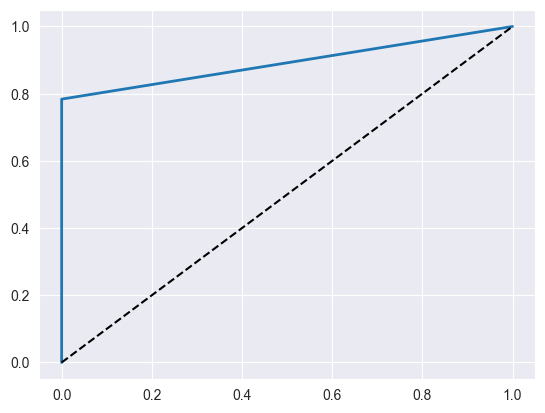

In [118]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred)

def plot_roc(fpr, tpr, label=None):
    plt.plot(fpr, tpr, label=label, linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--')

plot_roc(fpr, tpr)
plt.show()

### Zespół Extra-Trees

In [113]:
from sklearn.metrics import roc_auc_score, recall_score

ext_clf.fit(X_train_valid, y_train_valid)

y_pred = ext_clf.predict(X_test)

print("f2: ", fbeta_score(y_test, y_pred, beta=2))
print("roc_auc: ", roc_auc_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("Koszt: ", -CustomCost(X_with_amount=X)(ext_clf,X_test,y_test))

f2:  0.8100558659217877
roc_auc:  0.8918449963751033
Recall:  0.7837837837837838
Koszt:  7858.659999999998


In [114]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[42644,     4],
       [   16,    58]])

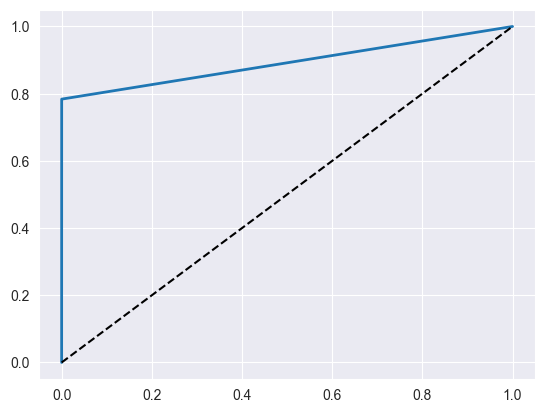

In [115]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred)

def plot_roc(fpr, tpr, label=None):
    plt.plot(fpr, tpr, label=label, linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--')

plot_roc(fpr, tpr)
plt.show()